In [1]:
import numpy as np
import pandas as pa 
from matplotlib import pyplot as plt 
%matplotlib inline
from qutip import *
import tqdm

## With cluster expansion 

###  preliminaries


In [402]:
sz_e = (sigmaz()-qeye(2))*0.5
sz = tensor(sz_e, qeye(2))
iz = tensor(qeye(2), sigmaz()*0.5)
ix = tensor(qeye(2), sigmax()*0.5)
#del(s_z)
pi_2_g_e_x = gates.rotation(op=sigmax(), phi=np.pi/2.0, N=2, target=0)
pi_2_g_e_y = gates.rotation(op=sigmay(), phi=np.pi/2.0, N=2, target=0)
pi_g_e_x = gates.rotation(op=sigmax(), phi=np.pi, N=2,target=0)
pi_g_e_x_alpha = gates.rotation(op=sigmax(), phi=np.pi*0.1, N=2,target=0)
pi_g_e_mx_alpha = gates.rotation(op=sigmax(), phi=-np.pi*0.1, N=2,target=0)
pi_g_e_y_alpha = gates.rotation(op=sigmay(), phi=np.pi*0.1, N=2,target=0)
pi_g_e_my_alpha = gates.rotation(op=sigmay(), phi=-np.pi*0.1, N=2,target=0)

56.3888888889


([array([1., 0., 0., 0., 2., 1., 2., 0., 0., 1.]),
  array([1., 0., 0., 0., 1., 2., 2., 0., 1., 0.])],
 array([-0.22246313, -0.16738656, -0.11230998, -0.05723341, -0.00215684,
         0.05291974,  0.10799631,  0.16307289,  0.21814946,  0.27322604,
         0.32830261]),
 <a list of 2 Lists of Patches objects>)

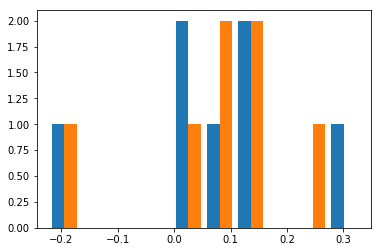

In [403]:
class NV:
    def __init__(self, c13_zz,c13_zx,B):
        self.C13_zz = c13_zz
        self.C13_zx = c13_zx
        self.B = B
        self.init_h()
        
    def init_h(self):
        self.H = []
        gamma_e = 2.8 #MHz/G
        gamma_n = 10.7*1e-4 # MHz/G
        for i,zz in enumerate(self.C13_zz):
            self.H.append(
                iz*gamma_n*B*2*np.pi + 2*np.pi*sz*iz*zz +
                2*np.pi*sz*ix*self.C13_zx[i]
            )        
                
    def evolve_i(self, rho, seq, i):        
        rho1 = rho
        for s in seq:
            if isinstance(s, Qobj):
                rho1 = s*rho1*s.dag()
            elif isinstance(s, float):
                #free_evolution
                #print('free')
                U = (self.H[i]*1j*s).expm()
                rho1 = U*rho1*U.dag()
            elif isinstance(s, dict):
                out = mesolve(rho0=rho1, H=self.H, c_ops=[tensor(sigmaz(),qeye(2))], tlist=np.linspace(0,s['T_c'], 10), 
                          options = Options(nsteps=1e5))
                return out.states[-1]                
        return rho1
    
    def experiment(self, seq, **kwargs):
        
        Pi = 1
        rho = tensor(fock_dm(2,0), qeye(2)*0.5)
        for i,zz in enumerate(self.C13_zz):
            
            rho1 = self.evolve_i(rho, seq(**kwargs),i)
            p0 = expect(sigmaz(), rho1.ptrace(0))
            Pi *= p0
        
        return Pi
    def hahn_echo(self,tau):
        seq = [
        pi_2_g_e_y, 
            tau, 
            pi_g_e_x,
            tau,
           pi_2_g_e_y.dag()
          ]
        return seq
    
    
    def xy4(self, tau):
        seq = [
        pi_2_g_e_y, 
            tau]
        
        for i in range(4):
            seq += [pi_g_e_x, tau]
                        
        
        seq += [pi_2_g_e_y.dag()]
        return seq
    
    def xy16(self, tau):
        seq = [
        pi_2_g_e_y, 
            tau]
        
        for i in range(16):
            seq += [pi_g_e_x, tau]
                        
        
        seq += [pi_2_g_e_y.dag()]
        return seq
    
    def xy_mxy16(self, tau):
        seq = [
        pi_2_g_e_y, 
            tau]
        
        for i in range(4):
            seq += [pi_g_e_x_alpha, tau]
            seq += [pi_g_e_mx_alpha, tau]
            seq += [pi_g_e_y_alpha, tau]
            seq += [pi_g_e_my_alpha, tau]
                        
        
        seq += [pi_2_g_e_y.dag()]
        return seq
    
    
    def corr_spectroscopy(self,tau,tc):
        seq = [
        pi_2_g_e_x, 
            tau, 
            pi_g_e_x,
            tau,
           pi_2_g_e_y.dag(),
            tc,
            pi_2_g_e_x, 
            tau, 
            pi_g_e_x,
            tau,
           pi_2_g_e_y.dag() 
          ]
        return seq
    
C13_zz_b = np.random.normal(loc = 0, scale =0.15, size=5)#[0.13, 0.13,0.1, 0.04,0.002,0.05, 0.1]
C13_zx_b = np.random.normal(loc=0,scale=0.15, size=5)

C13_zz = np.array([-200.73436071,52.2228743806])*1e-3
C13_zx = np.array([73.365909271,143.61522982])*1e-3
#C13_zz = np.array([-165.824927315,17.313440985])*1e-3
#C13_zx = np.array([149.780968076,137.103621041])*1e-3

B = 60.9e-3 / 10.8 *1e4; print(B)


C13_zz = np.append(C13_zz, C13_zz_b)
C13_zx = np.append(C13_zx, C13_zx_b)

mynv = NV(B=50, c13_zx=C13_zz, c13_zz=C13_zx)
plt.hist([C13_zz, C13_zx])
#plt.hist(C13_zx)


### DD run

In [406]:
Pxy4 = []
Phe = []
Pxy16 = []
taus = np.linspace(0,50,200)
#rho = tensor(se+sz,se)
for tau in tqdm.tqdm_notebook(taus):
    #P.append(mynv.experiment(seq=mynv.xy4,tau=tau))
    Pxy4.append(mynv.experiment(seq=mynv.xy_mxy16,tau=tau))
    Pxy16.append(mynv.experiment(seq=mynv.xy16,tau=tau))
    Phe.append(mynv.experiment(seq=mynv.hahn_echo,tau=tau))
    

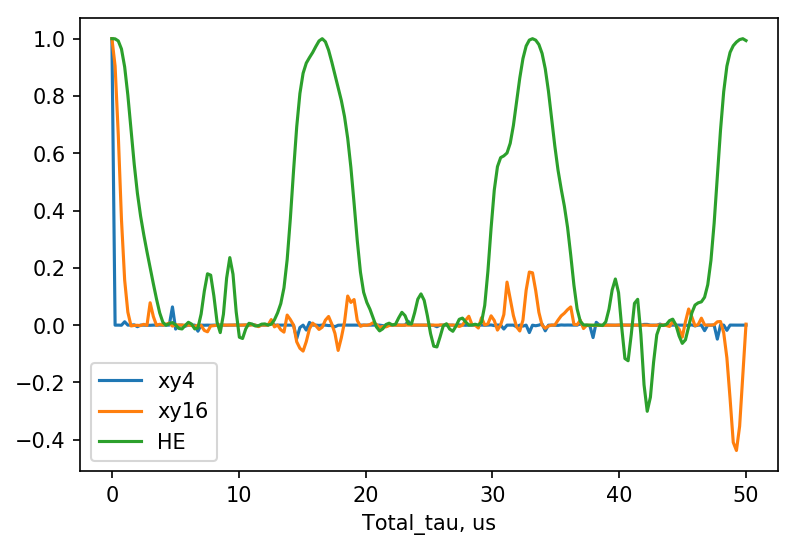

In [407]:
plt.figure(dpi=150)
#T2 = 100
plt.plot(taus, np.array(Pxy4), label = 'xy4')
plt.plot(taus, np.array(Pxy16), label = 'xy16')
plt.plot(taus, np.array(Phe), label = 'HE')
plt.xlabel('Total_tau, us')
plt.legend()
plt.savefig('he_xy4_xy16.png')

### Correlation spectroscopy


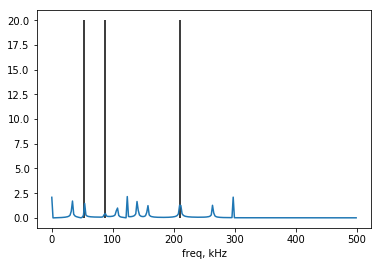

In [307]:
wl = gamma_n*B
plt.plot(np.fft.rfftfreq(d = T_c[1]-T_c[0], n = len(P))*1e3,np.abs(np.fft.rfft(P)))
plt.xlabel('freq, kHz')
plt.vlines(x=wl*1e3, ymin=0, ymax = 20)
for i,_ in enumerate(mynv.C13_zz):
    zz = C13_zz[i]
    zx = C13_zx[i]
    wl_1 = ((wl-zz)**2 + zx**2)**0.5
    plt.vlines(x=wl_1*1e3, ymin=0, ymax = 20)
#plt.xlim(0,800)
plt.yscale('linear')

## TODO: DD instead of hahn echo

The idea would be to use it together with scan of the tau, to make a proper 2D spectroscopy of the bath, to select better with tau and scan it with T_c, but at small fields, the tau is too big already. However if it is 0.1 MHz, then it is total 10 us so it actually one hahn echo already enough to saturate the sensor. So, the problem here is that we can sens it with DD. Unless we fine tune to the small bath. 

## 2D simulation with DQ T in between... to link the peaks between first and second...

Because we could correlat with a DQ $\pi$ pulse we could the see which peak in the beginning affected the phase of the second evolution

In [106]:
C13_zz = np.random.uniform(high=0.15,low=-0.15,size=1)#[0.13, 0.13,0.1, 0.04,0.002,0.05, 0.1]
C13_zx = np.random.uniform(high=0.15,low=-0.15,size=1)#[0.12,0.12,0.03,0.12, 0.001,0.001,0.02]

s_z_e = (sigmaz()-qeye(2))*0.5
s_z_c = tensor(s_z_e, qeye(2))
iz_c = []
ix_c = []
for i,azz in enumerate(C13_zz):
    
    iz_c.append(tensor(qeye(2), sigmaz()*0.5))
    ix_c.append(tensor(qeye(2), sigmax()*0.5))
    
pi_2_g_e_x = gates.rotation(op=sigmax(), phi=np.pi/2.0, N=2, target=0)
pi_2_g_e_y = gates.rotation(op=sigmay(), phi=np.pi/2.0, N=2, target=0)
pi_g_e_x = gates.rotation(op=sigmax(), phi=np.pi, N=2,target=0)

B = 50 #G
gamma_e = 2.8 #MHz/G
gamma_n = 10.7*1e-4 # MHz/G
H0_1 = []
H0_m1 = []
for i,zz in enumerate(C13_zz):
    H0_1.append(
        iz_c[i]*gamma_n*B*2*np.pi + 2*np.pi*s_z_c*iz_c[i]*zz + 2*np.pi*s_z_c*ix_c[i]*C13_zx[i])
    H0_m1.append(
        iz_c[i]*gamma_n*B*2*np.pi + 2*np.pi*s_z_c*iz_c[i]*(-1.0*zz) - 2*np.pi*s_z_c*ix_c[i]*C13_zx[i])


def corr_spectroscopy_inverted(rho, tau, T_c1, T_c2):
    Pi = 1
    seq = [
        pi_2_g_e_x, 
            tau, 
            pi_g_e_x,
            tau,
           pi_2_g_e_y,
          T_c1,
          #'swap',
          #T_c2,## Maybe dephasing here?
        pi_2_g_e_x, 
            tau, 
            pi_g_e_x,
            tau,
           pi_2_g_e_y
          ]
    for i,zz in enumerate(C13_zz):
        rho1 = evolve_i_with_swap(rho, seq,i)
        p0 = expect(sigmaz(), rho1.ptrace(0))
        Pi *= p0
    #Px = (M+1)/2
    
    return Pi#Px

def evolve_i_with_swap(rho,seq,i):
    rho1 = rho
    H01 = H0_1
    for s in seq:
        if isinstance(s, Qobj):
            rho1 = s*rho1*s.dag()
        elif s =='swap':
            print('inverted')
            #H01 = H0_m1
        elif isinstance(s, float):
            #print(s)
            U = (H01[i]*1j*s).expm()
            rho1 = U*rho1*U.dag()
        
            
            
    return rho1


In [107]:
C13_zx, C13_zz

(array([-0.14800798]), array([0.04098774]))

In [108]:
P = []
taus = [3.5]
T_c = np.linspace(1,500,500)
rho = tensor(se+sz,*[se])
for T_ci in tqdm.tqdm_notebook(T_c):
    for tau in taus:
        P.append(corr_spectroscopy_inverted(rho=rho, tau=tau, T_c1=T_ci,T_c2=0.0))

Text(0.5,1,'azz[0.04098774]azx[-0.14800798]')

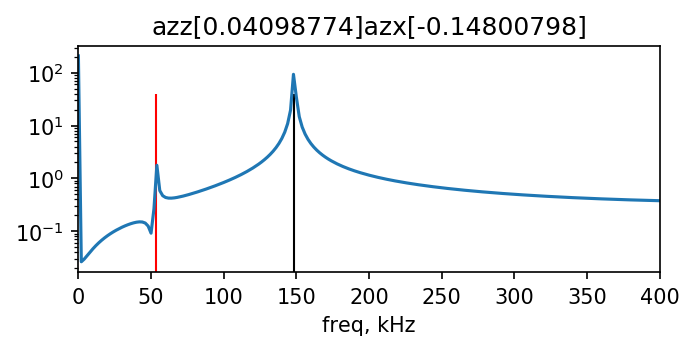

In [109]:
wl = gamma_n*B
plt.figure(dpi=150,figsize=(5,2))
plt.plot(np.fft.rfftfreq(d = T_c[1]-T_c[0], n = len(P))*1e3,np.abs(np.fft.rfft(P)))
plt.xlabel('freq, kHz')

for i in range(len(C13_zx)):
    zz = C13_zz[i]
    zx = C13_zx[i]
    wl_1 = ((wl-zz)**2 + zx**2)**0.5
    plt.vlines(x=wl*1e3, ymin=0, ymax = 40, lw = 1,color='r')
    plt.vlines(x=wl_1*1e3, ymin=0, ymax = 40, lw = 1)
plt.xlim(0,400)
plt.yscale('log')
plt.title('azz{}azx{}'.format(C13_zz,C13_zx))
#plt.savefig('c13_{}.png'.format(len(C13_zz)))

In [311]:
P = []
taus = [3.5]
T_c = np.linspace(1,100,50)
T_c2 = np.linspace(1,100,50)
rho = tensor(se+sz,*[se]*1)
for T_ci in tqdm.tqdm_notebook(T_c):
    for T_ci2 in T_c2:
        P.append(corr_spectroscopy_inverted(rho=rho, tau=tau, T_c1=T_ci,T_c2=T_ci2))

TypeError: Incompatible quantum object dimensions

In [309]:
d = np.array(P).reshape(50,50)
plt.pcolormesh(d)

ValueError: cannot reshape array of size 501 into shape (50,50)

In [ ]:
dt = lambda x: x[1]-x[0]
fft_freq1 = np.fft.rfftfreq(n=d.shape[0], d= dt(T_c))
fft_freq1_f = np.fft.fftfreq(n=d.shape[0], d= dt(T_c))
fft_freq2 = np.fft.rfftfreq(n=d.shape[1], d=dt(T_c2))

plt.plot(fft_freq1,np.abs(np.fft.rfft(d[:,0])))
plt.plot(fft_freq2, np.abs(np.fft.rfft(d[0,:])))

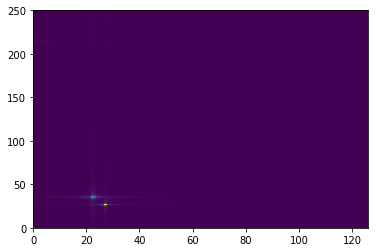

In [310]:
plt.pcolormesh(np.abs(np.fft.rfft2(d)))